In [1]:
import numpy as np

In [2]:
from modules import experimental_data as expdata
import modules.experimental_rir as exprir
from modules import randomized_ir, utils, mcmc, adc
import modules.plots.experimental_data as exp_plots
import modules.plots.deconvolution as dec_plots

from modules_reloader import reloader
relmod = reloader(expdata, exp_plots, dec_plots, randomized_ir, utils, mcmc, adc, exprir)

In [42]:
relmod()

In [4]:
e = expdata.Event(10675)

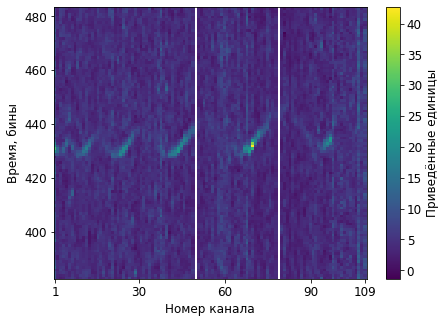

In [43]:
filename = 'experimental-frame-example'
# filename = None

f, a  = exp_plots.plot_signals_frame(e, units='scaled', filename=filename)

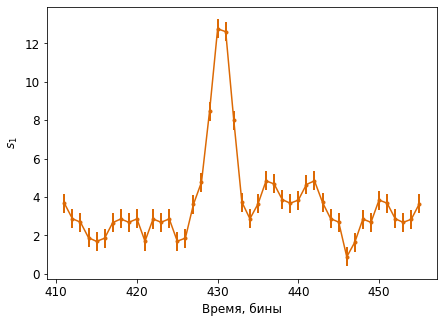

In [27]:
N = 45
i_ch = 1

s_vec_t, s_vec, adc_step = e.signal_in_channel(i_ch, window=N)

f, a = exp_plots.plot_signal_in_channel(e, i_ch, window=N)

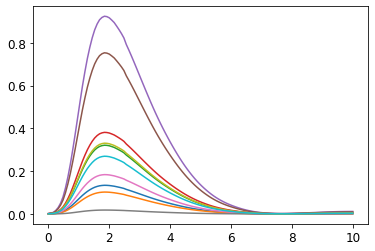

In [7]:
ir_t, ir_shape = exprir.read_ir_shape()
ir_t, ir_shape = exprir.cut_ir_shape(ir_t, ir_shape, excluded_integral_percentile=0.02)

rir = randomized_ir.RandomizedIr(ir_x=ir_t, ir_y=ir_shape, factor=exprir.generate_C_pmt)
L = rir.L

rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10**7)

rir.plot_realizations()

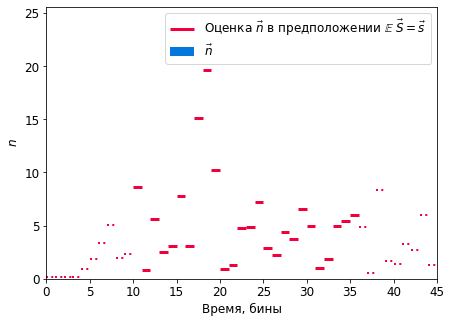

In [8]:
n_vec_estimation = rireff.estimate_n_vec(s_vec, delta=adc_step)
f, a = dec_plots.plot_mean_n_estimation(np.zeros_like(n_vec_estimation), n_vec_estimation, L)

In [9]:
ll_fact = rireff.get_loglikelihood_independent_normdist(s_vec, delta=adc_step, density=False)
ll_fact(n_vec_estimation)  # let the numba do the trick
ll_mvn = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=False)

In [10]:
result_preliminary = mcmc.run_mcmc(
    logposterior=ll_fact,
    init_point=n_vec_estimation,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=128,
        n_samples=30000,
        progress_bar=True,
        # autocorr_estimation_each=3000,
        # debug_acceptance_fraction_each=500,
    ) 
)

100%|██████████| 30000/30000 [00:22<00:00, 1334.29it/s]


In [11]:
tau = result_preliminary.sampler.get_autocorr_time(quiet=True).mean()

N/50 = 600;
tau: [2967.16473842 3742.48702837 3555.59611119 3353.34503153 2792.62890027
 2795.45958478 2661.55403223 3048.93556138 2863.90589227 2835.11807958
 3252.25471606 2971.75080595 3386.69634872 2703.58353623 2834.39353129
 2971.94228498 2940.19460656 2910.03071292 3112.01529815 3150.49273343
 2724.68081656 2804.9112289  3035.28606091 2892.7315518  2834.53278388
 2794.17152045 2833.77784702 2815.07312533 2885.47555679 2961.00321284
 3052.5511622  2823.0741599  2848.43850093 3235.11537706 3201.24923605
 2968.17217591 2961.56708922 3455.88102174 3378.68510117 3179.79838901
 3304.73326662 3012.86169451 2944.41496179 2963.31541226 3061.15916762]


In [12]:
n_walkers_final = 128

init_pts = mcmc.extract_independent_sample(result_preliminary.sampler, desired_sample_size=n_walkers_final)

In [13]:
result = mcmc.run_mcmc(
    logposterior=ll_mvn,
    init_point=init_pts,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers_final,
        n_samples=4 * tau,
        progress_bar=True,
        starting_points_strategy='given',
    )
)

100%|██████████| 12073/12073 [31:40<00:00,  6.35it/s]


In [14]:
sample_preliminary = mcmc.extract_independent_sample(result_preliminary.sampler, tau_override=tau, debug=True)
sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau, debug=True)

Autocorrelation time is estimated at 3018.271332328004 (ranges from 3018.271332328004 to 3018.271332328004)
Burn-in = 6036 samples
Thinning = 2716 samples
Autocorrelation time is estimated at 3018.271332328004 (ranges from 3018.271332328004 to 3018.271332328004)
Burn-in = 6036 samples
Thinning = 2716 samples


In [29]:
relmod()

/home/njvh/Documents/Science/sphere/thesis/modules/plots/deconvolution.py:233: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.set_ylim(bottom=0, top=top_defining_values.max() * 1.7)


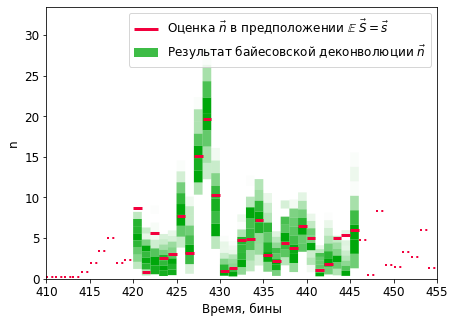

In [30]:
filename = 'experimental-signal-deconvolution-example'

f, a = dec_plots.plot_bayesian_mean_estimation(None, sample, L, n_vec_estimation, filename=filename, signal_t=s_vec_t)